Проект анализ бизнес-показателей. 

# Вводные данные

**Канал:** развлекательное приложение Procrastinate Pro+

**Проблема:** огромные вложения в рекламу, последние несколько месяцев компания терпит убытки

**Задача:** разобраться в причинах и помочь компании выйти в плюс.

**Дано:**
- Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
    - лог сервера с данными об их посещениях,
    - выгрузка их покупок за этот период,
    - рекламные расходы.

**Предстоит изучить:**
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Описание данных

Файл **`visits_info_short.csv`** хранит лог сервера с информацией о посещениях сайта, 

**`orders_info_short.csv`** — информацию о заказах, 

а **`costs_info_short.csv`** — информацию о расходах на рекламу.

### Структура **visits_info_short.csv:**

**`User Id`**— уникальный идентификатор пользователя,

**`Region`**— страна пользователя,

**`Device`** — тип устройства пользователя,

**`Channel`** — идентификатор источника перехода,

**`Session Start`**— дата и время начала сессии,

**`Session End`**— дата и время окончания сессии.


### Структура **orders_info_short.csv:**

**`User Id`**— уникальный идентификатор пользователя,

**`Event Dt`** — дата и время покупки,

**`Revenue`** — сумма заказа.

### Структура **costs_info_short.csv:**

**`dt`** — дата проведения рекламной кампании,

**`Channel`**— идентификатор рекламного источника,

**`costs`** — расходы на эту кампанию.

### Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### **Ход работы**

1. Загрузить данные и подготовьте их к дальнейшему анализу
2. Задать функции для расчёта и анализа LTV, ROI, удержания и конверсии
3. Провести исследовательский анализ данных
4. Провести маркетинговый анализ
5. Оцените окупаемость рекламы
6. Написать выводы

## Загрузка данных и подготовка их к анализу




**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
# импортируем все необходимые библиотеки, которые могут понадобиться в исследовании
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from scipy import stats as st

In [2]:
# чтение файла с данными и сохранение в visits, orders, costs
try:
    visits = pd.read_csv('/Users/imac/Downloads/visits_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    
try:
    orders = pd.read_csv('/Users/imac/Downloads/orders_info_short.csv')
except:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    
try:
    costs = pd.read_csv('/Users/imac/Downloads/costs_info_short.csv')
except:
    costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
#Функция получения первичной информации о датафрейме

def first_look (data):
    print('---------Первые 10 строк-----------')
    display(data.head(10))
    print('---------Последние 10 строк---------')
    display(data.tail(10))
    print('---------Типы данных---------------\n')
    display(data.info())
    print('---------Статистическая сводка---------------')
    display(data.describe())
    print('---------Пропуски-----------\n')
    display(data.isna().sum())
    print('\n---------Процент пропусков от всего датасета-----------')
    display(data.isna().mean().sort_values(ascending=False)*100)
    print('\n---------Дубликаты-----------\n')
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Дубликатов НЕТ')

Ознакомимся с каждым датафреймом и сделаем предобработку

### VISITS

In [4]:
first_look(visits)#ознакомление

---------Первые 10 строк-----------


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


---------Последние 10 строк---------


,User Id,Region,Device,Channel,Session Start,Session End
309891,136940622331,France,Android,AdNonSense,2019-10-31 17:12:29,2019-10-31 17:15:11
309892,69556000475,UK,iPhone,AdNonSense,2019-10-31 01:26:31,2019-10-31 01:39:21
309893,805154517300,France,iPhone,LeapBob,2019-10-31 07:07:13,2019-10-31 07:38:52
309894,207948856745,France,PC,WahooNetBanner,2019-10-31 11:38:01,2019-10-31 11:50:29
309895,95774241409,UK,PC,OppleCreativeMedia,2019-10-31 11:14:15,2019-10-31 11:50:29
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55
309900,109329042535,Germany,PC,lambdaMediaAds,2019-10-31 14:17:43,2019-10-31 15:17:04


---------Типы данных---------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

---------Статистическая сводка---------------


,User Id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


---------Пропуски-----------



User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64


---------Процент пропусков от всего датасета-----------


User Id          0.0
Region           0.0
Device           0.0
Channel          0.0
Session Start    0.0
Session End      0.0
dtype: float64


---------Дубликаты-----------

Дубликатов НЕТ


Обнаруженные проблемы:

1. типы данных в Session Start и Session End необходимо перевести в datetime
2. следует изменить названия столбцов на snake_case

In [5]:
visits.columns

Index(['User Id', 'Region', 'Device', 'Channel', 'Session Start',
       'Session End'],
      dtype='object')

In [6]:
visits = visits.rename(columns={'User Id':'user_id', 
                        'Region':'region',
                        'Device':'device',
                        'Channel':'channel', 
                        'Session Start':'session_start', 
                        'Session End':'session_end'}) # переименование столбцов

In [7]:
visits.columns # проверка результатов - перечень названий столбцов

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format = '%Y-%m-%d %H:%M:%S') #перевод в дату
visits['session_end'] = pd.to_datetime(visits['session_end'], format = '%Y-%m-%d %H:%M:%S') #перевод в дату

In [9]:
visits.info() #проверим все еще раз

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


### ORDERS

In [10]:
first_look(orders)#ознакомление

---------Первые 10 строк-----------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


---------Последние 10 строк---------


,User Id,Event Dt,Revenue
40202,981966082461,2019-10-31 15:19:00,4.99
40203,43843333146,2019-10-31 21:45:38,4.99
40204,436309219475,2019-10-31 18:49:29,4.99
40205,662522538439,2019-10-31 09:38:22,4.99
40206,580962171213,2019-10-31 03:23:40,4.99
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99
40211,329994900775,2019-10-31 13:29:06,4.99


---------Типы данных---------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

---------Статистическая сводка---------------


,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


---------Пропуски-----------



User Id     0
Event Dt    0
Revenue     0
dtype: int64


---------Процент пропусков от всего датасета-----------


User Id     0.0
Event Dt    0.0
Revenue     0.0
dtype: float64


---------Дубликаты-----------

Дубликатов НЕТ


Наблюдаются такие же проблемы, как и у visits. Необходимо поменять названия колонок и перевести колонку с временем покупки в дату

In [11]:
orders.columns

Index(['User Id', 'Event Dt', 'Revenue'], dtype='object')

In [12]:
orders = orders.rename(columns={'User Id':'user_id', 
                        'Event Dt':'event_dt',
                        'Revenue':'revenue'}) # переименование столбцов

In [13]:
orders.columns #проверка

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [14]:
orders['event_dt'] = pd.to_datetime(
    orders['event_dt'], format = '%Y-%m-%d %H:%M:%S') #перевод в дату

In [15]:
orders.info()#проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


### COSTS

In [16]:
first_look(costs)#ознакомление

---------Первые 10 строк-----------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


---------Последние 10 строк---------


,dt,Channel,costs
1790,2019-10-18,lambdaMediaAds,8.0
1791,2019-10-19,lambdaMediaAds,5.6
1792,2019-10-20,lambdaMediaAds,8.8
1793,2019-10-21,lambdaMediaAds,7.2
1794,2019-10-22,lambdaMediaAds,6.4
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8
1799,2019-10-27,lambdaMediaAds,12.0


---------Типы данных---------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

---------Статистическая сводка---------------


,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


---------Пропуски-----------



dt         0
Channel    0
costs      0
dtype: int64


---------Процент пропусков от всего датасета-----------


dt         0.0
Channel    0.0
costs      0.0
dtype: float64


---------Дубликаты-----------

Дубликатов НЕТ


In [17]:
costs.columns

Index(['dt', 'Channel', 'costs'], dtype='object')

In [18]:
costs = costs.rename(columns={'dt':'dt', 
                        'Channel':'channel',
                        'costs':'costs'}) # переименование столбцов

In [19]:
costs.columns #проверка

Index(['dt', 'channel', 'costs'], dtype='object')

In [20]:
costs['dt'] = pd.to_datetime(
    costs['dt'], format = '%Y-%m-%d')

In [21]:
costs.info()#проверим все еще раз

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


### Итог

Серьезных проблем в датасетах не найдено. Были исправлены названия колонок и колонки, содержащие время или дату приведены к правильному типу. Аномалий, дубликатов и пропусков в датафреймах нет. 

## Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [22]:
def get_profiles(visits, orders):
 # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим первые значения session_start и channel
    # столбец с временем первого посещения назовём first_ts
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
 # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    # эти данные понадобятся для когортного анализа
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # проверяем, есть ли ID пользователей из profiles в orders
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique()) #ваш код здесь
 
    return profiles

In [23]:
profiles = get_profiles(visits,orders)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False
...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False


Результат — 150008 пользовательских профилей, в каждом из которых есть данные о дате первого посещения и рекламном источнике, который мотивировал пользователя посетить интернет-магазин. Такие данные значительно упрощают дальнейший анализ. 

Имея готовые профили пользователей, легко узнать количество привлечённых каждым источником посетителей. Достаточно сгруппировать профили по рекламному каналу и посчитать количество уникальных ID функцией


In [24]:
profiles.groupby(
    'channel').agg(
    {'user_id' : 'nunique'}).sort_values(
    by='user_id', ascending=False)


,user_id
channel,
organic,56439
FaceBoom,29144
TipTop,19561
OppleCreativeMedia,8605
LeapBob,8553
WahooNetBanner,8553
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


количество привлечённых каждым источником посетителей  👆🏻

In [25]:
profiles.groupby(
    'channel').agg(
    {'payer' : 'mean'}).sort_values(
    by='payer', ascending=False)

,payer
channel,
FaceBoom,0.122049
AdNonSense,0.113402
lambdaMediaAds,0.104700
TipTop,0.096007
RocketSuperAds,0.079137
WahooNetBanner,0.052964
YRabbit,0.038265
MediaTornado,0.035747
LeapBob,0.030633


**доля новых посетителей для каждого канала 👆**

Построим график, отображающий динамику привлечения новых пользователей по каждому из рекламных каналов.

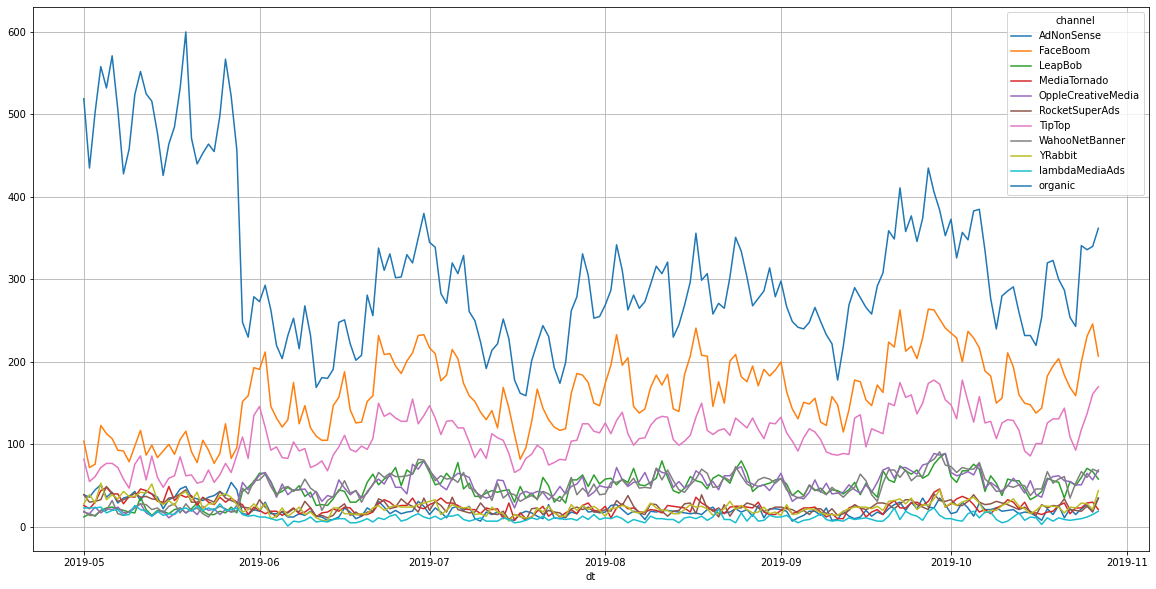

In [26]:
%matplotlib inline

profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(20, 10), grid=True)

plt.show()

За полгода новые посетители чаще всего приходили из источника Organic, а реже всего — из lambaMediaAds. Среди источников можно выделить три главных, которые привлекают наибольшее кол-во новых пользователей – это Organic, FaceBoom и TipTop. 

In [27]:
display('мин дата привлечения', profiles.first_ts.min())
display('макс дата привлечения', profiles.first_ts.max())

'мин дата привлечения'

Timestamp('2019-05-01 00:00:41')

'макс дата привлечения'

Timestamp('2019-10-27 23:59:04')

**первый пользователь был привлечен 1 мая 2019 года,
а последний привлеченный пользователь был привлечен 27 октября 2019 года 👆**

Следовательно данные из технического задания соответсвуют действительности. В итоге мы имеем данные почти за 6 месяцев. 

In [28]:
profiles.groupby(
    'region').agg(
    {'payer' : 'mean'}).sort_values(
    by='payer', ascending=False)*100

,payer
region,
United States,6.901862
Germany,4.111875
UK,3.982930
France,3.799427


**доля новых посетителей в каждой стране в процентах 👆**

In [29]:
profiles.groupby(
    'region').agg(
    {'payer' : 'sum'}).sort_values(
        by='payer', ascending=False)

,payer
region,
United States,6902
UK,700
France,663
Germany,616


**Больше всего платящих пользователей приходится на Соединенные Штаты 👆**

In [30]:
profiles.groupby(
    'device').agg(
    {'payer' : 'mean'}).sort_values(
    by='payer', ascending=False)

,payer
device,
Mac,0.063644
iPhone,0.062079
Android,0.058518
PC,0.050468


**доля новых посетителей по девайсам 👆**

In [31]:
profiles.groupby(
    'device').agg(
    {'user_id' : 'nunique'}).sort_values(
    by='user_id', ascending=False)


,user_id
device,
iPhone,54479
Android,35032
PC,30455
Mac,30042


**Чаще всего пользователи пользуются айфонами👆**

In [32]:
profiles.groupby(
    'device').agg(
    {'payer' : 'sum'}).sort_values(
    by='payer', ascending=False)

,payer
device,
iPhone,3382
Android,2050
Mac,1912
PC,1537


Платящие тоже предпочитают айфоны

In [33]:
profiles.groupby(
    'channel').agg(
    {'user_id' : 'nunique'}).sort_values(
    by='user_id', ascending=False)


,user_id
channel,
organic,56439
FaceBoom,29144
TipTop,19561
OppleCreativeMedia,8605
LeapBob,8553
WahooNetBanner,8553
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


Построим график, отображающий динамику привлечения новых пользователей по каждому из регионов.

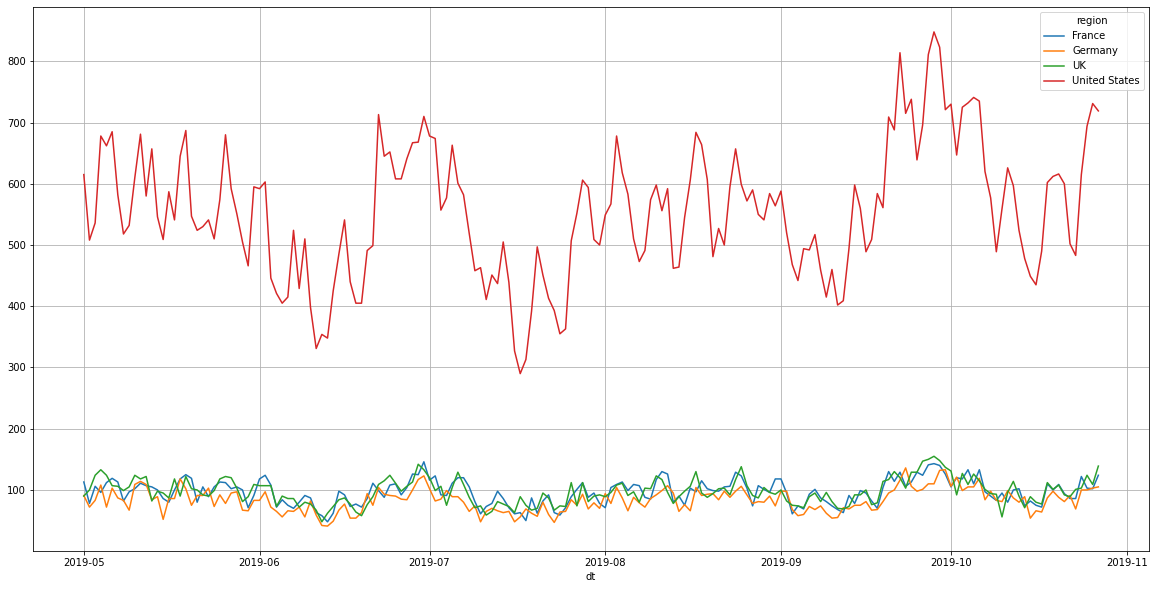

In [34]:
%matplotlib inline

profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='region',  # регионы 
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(20, 10), grid=True)

plt.show()

Как видно из графика, приложение чаще всего устанавливается в Соединенных штатах. 👆

Построим график, отображающий динамику привлечения новых пользователей по каждому из девайсов.

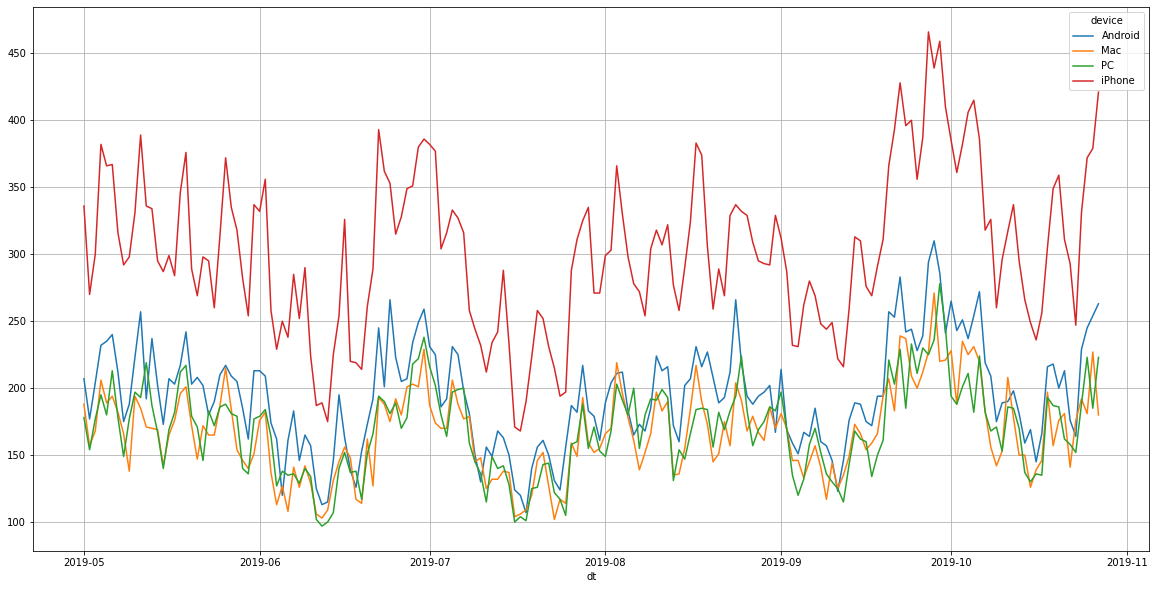

In [35]:
%matplotlib inline

profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='device',  # девайсы
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(20, 10), grid=True)

plt.show()

По графику видно, что большинство людей пользуются айфонами 👆

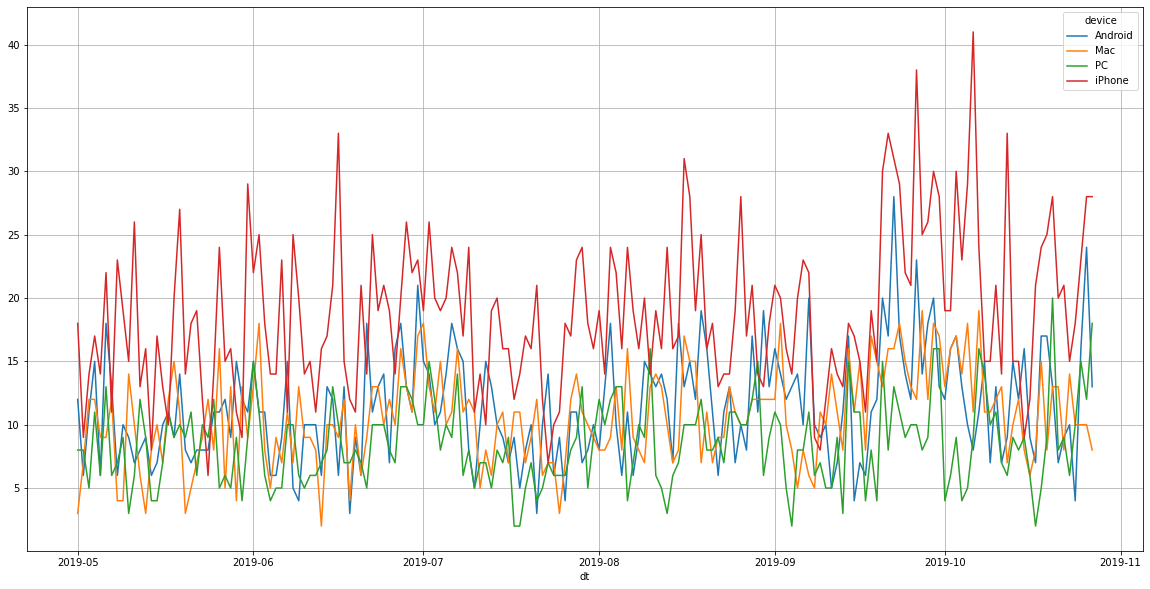

In [36]:
%matplotlib inline

profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='device',  # девайсы
    values='payer',  # ID пользователей
    aggfunc='sum'  # подсчёт уникальных значений
).plot(figsize=(20, 10), grid=True)

plt.show()

Платящие пользователи предпочитают пользоваться айфоном 👆

### Итог

- Минимальную и максимальные даты привлечения пользователей.
    - минимальный - '2019-05-01 00:00:41'
    - максимальный - '2019-10-27 23:59:04'
- В основном пользователи приходят из Соединенных Штатов, платящих пользователей больше всего приходится на Соединенные Штаты
- В основном пользователи пользуются айфонами, платящих пользователей больше всего приходится айфоны
- Через FaceBoom пришло больше всего платящих пользователей. 

## Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Общая сумма расходов на маркетинг

In [37]:
costs['costs'].sum().round(2)

105497.3

всего 👆🏻

In [38]:
costs_channel = costs.groupby('channel')['costs'].sum()

In [39]:
costs_channel.sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

количество денег, потраченных на определенный канал 👆🏻

In [40]:
costs['week_number'] = costs['dt'].dt.week

/tmp/ipykernel_104/3319344052.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  costs['week_number'] = costs['dt'].dt.week


In [41]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]').dt.date

In [42]:
costs_month = costs.groupby('costs_month')['costs'].sum().reset_index()

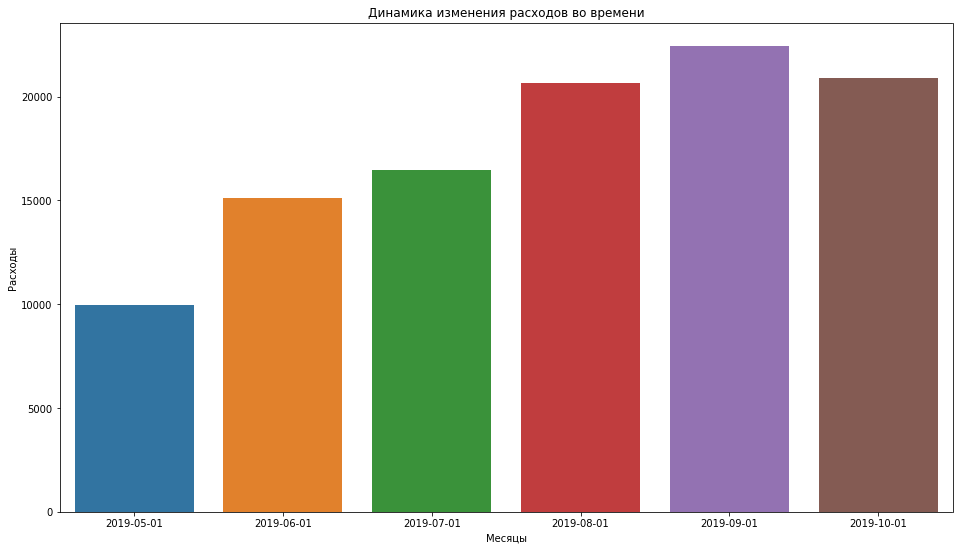

In [43]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="costs_month", y="costs", data=costs_month)
plt.title('Динамика изменения расходов во времени')
ax.set_xlabel('Месяцы')
ax.set_ylabel('Расходы')
plt.show()

На графике видно, что бюджеты на рекламу постоянно увеличивались и лишь в последний месяц компания решила немного убавить свои расходы на привлечение клиентов. 

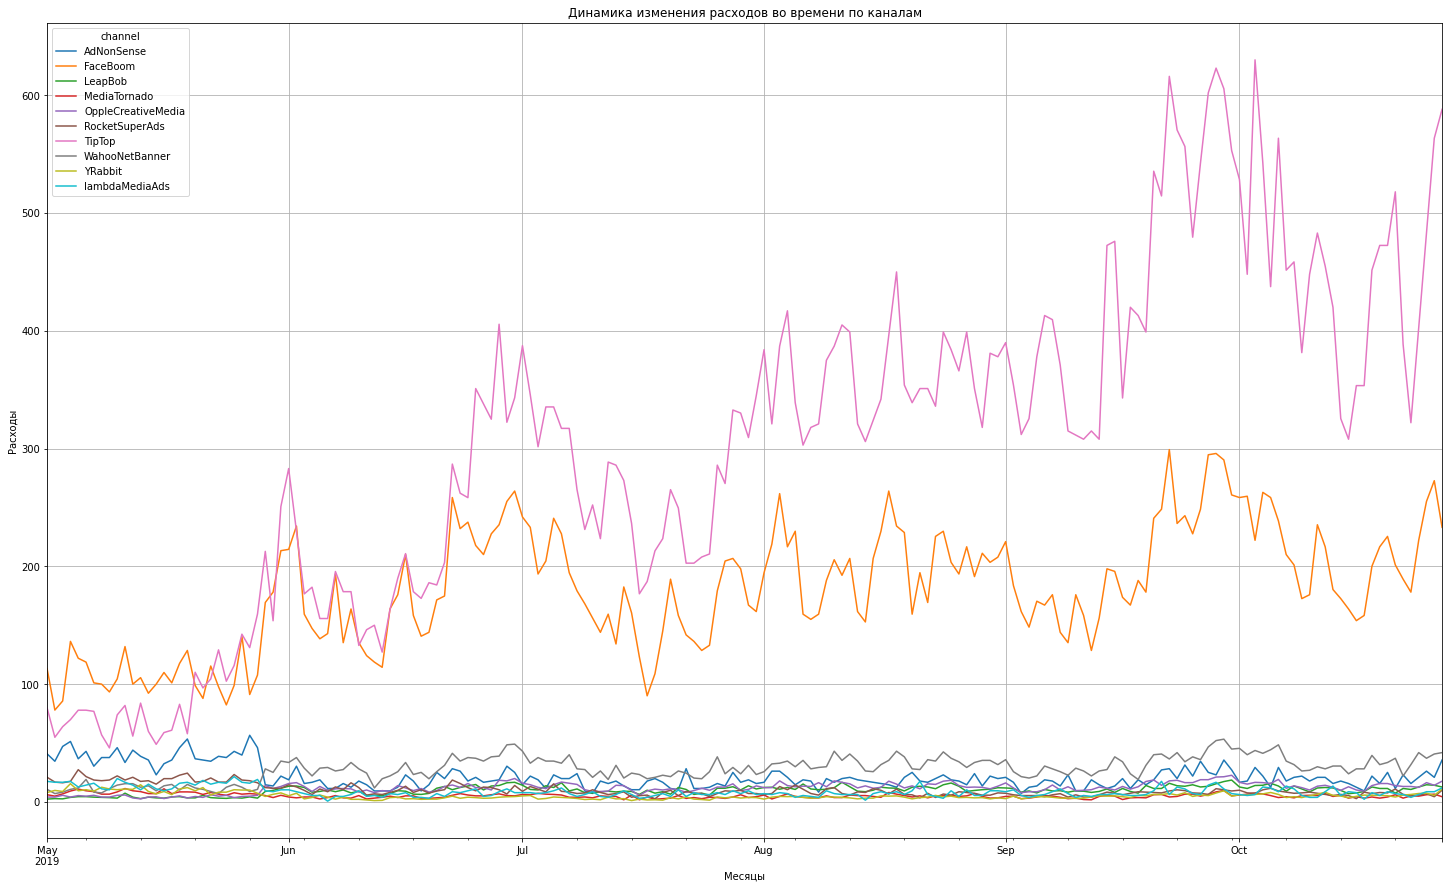

In [44]:
%matplotlib inline

costs.pivot_table(
    index='dt',  # даты трат
    columns='channel',  # источники переходов
    values='costs',  # кол-во трат
    aggfunc='sum'  # сумма за период

).plot(figsize=(25, 15), grid=True)
plt.title('Динамика изменения расходов во времени по каналам')
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.show()

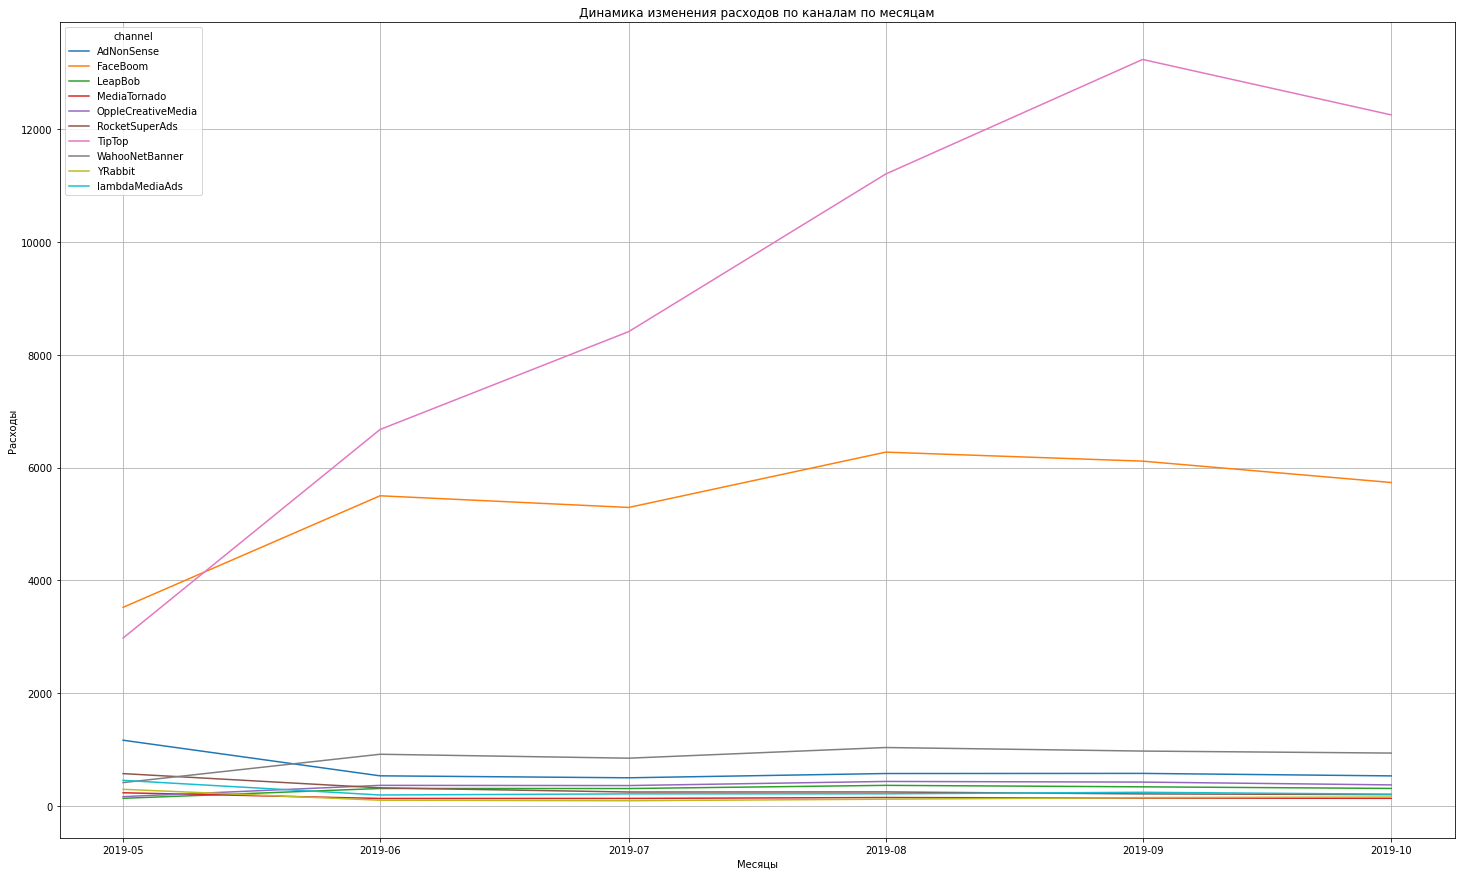

In [45]:
%matplotlib inline
costs.pivot_table(
    index='costs_month',  #по месяцам
    columns='channel',  # источники переходов
    values='costs',  # кол-во трат
    aggfunc='sum'  # сумма за период

).plot(figsize=(25, 15), grid=True)
plt.title('Динамика изменения расходов по каналам по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.show()

На данном графике видно, что на каналы Tip Top и FaceBoom уходило гораздо больше денег, чем на любые другие каналы. 👆🏻

In [46]:
costs_channel_cac = costs.groupby('channel').agg({'costs':'sum'})
costs_channel_cac.reset_index()

,channel,costs
0,AdNonSense,3911.25
1,FaceBoom,32445.60
2,LeapBob,1797.60
3,MediaTornado,954.48
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,TipTop,54751.30
7,WahooNetBanner,5151.00
8,YRabbit,944.22
9,lambdaMediaAds,1557.60


создали таблицу, чтобы посчитать дальнейший САС (затраты по источникам) 👆🏻

In [47]:
users_channel = (orders.merge(
    profiles, on='user_id', how='inner')).groupby(
    'channel').agg({'user_id':'nunique'}).rename(columns={'user_id':'customers'})

In [48]:
users_channel.reset_index()

,channel,customers
0,AdNonSense,440
1,FaceBoom,3557
2,LeapBob,262
3,MediaTornado,156
4,OppleCreativeMedia,233
5,RocketSuperAds,352
6,TipTop,1878
7,WahooNetBanner,453
8,YRabbit,165
9,lambdaMediaAds,225


количество юзеров, привлеченных через конкретный канал 👆🏻

In [49]:
cac = users_channel.join(costs_channel_cac).reset_index()
cac

,channel,customers,costs
0,AdNonSense,440,3911.25
1,FaceBoom,3557,32445.60
2,LeapBob,262,1797.60
3,MediaTornado,156,954.48
4,OppleCreativeMedia,233,2151.25
5,RocketSuperAds,352,1833.00
6,TipTop,1878,54751.30
7,WahooNetBanner,453,5151.00
8,YRabbit,165,944.22
9,lambdaMediaAds,225,1557.60


добавили потраченные деньги по каналам

In [50]:
cac = cac.fillna(0) #заполняем пробел для organic

In [51]:
cac['cac'] = cac['costs'] / cac['customers']
cac.sort_values('cac', ascending = False) #cac по убыванию

,channel,customers,costs,cac
6,TipTop,1878,54751.30,29.154047
7,WahooNetBanner,453,5151.00,11.370861
4,OppleCreativeMedia,233,2151.25,9.232833
1,FaceBoom,3557,32445.60,9.121619
0,AdNonSense,440,3911.25,8.889205
9,lambdaMediaAds,225,1557.60,6.922667
2,LeapBob,262,1797.60,6.861069
3,MediaTornado,156,954.48,6.118462
8,YRabbit,165,944.22,5.722545
5,RocketSuperAds,352,1833.00,5.207386


посчитали САС

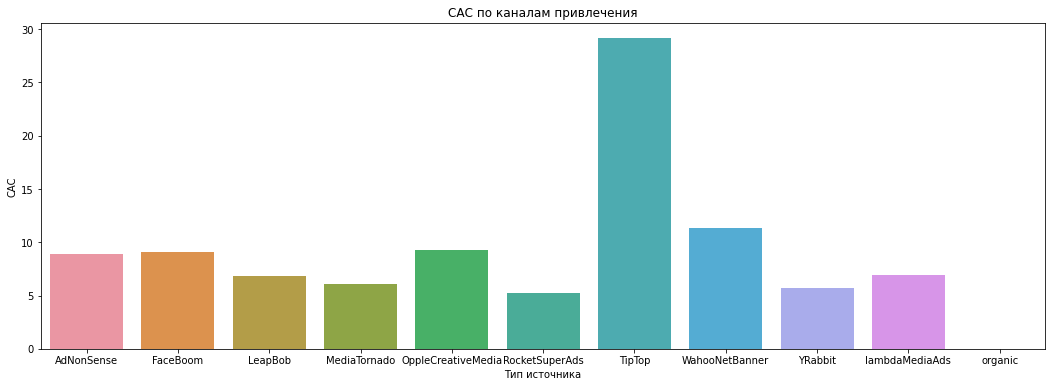

In [52]:
plt.figure(figsize = (18, 6))
ax = sns.barplot(x="channel", y="cac", data=cac)
plt.title('САС по каналам привлечения')
ax.set_xlabel('Тип источника')
ax.set_ylabel('CAC')
plt.show()

Получается, что самое дорогое привлечение идет через канал tip top 👆🏻

остальные каналы привлечения не превышают 11,4, и не бывают ниже 5,2 (organic не считается)

### Итог

1. Общая сумма всех расходов составляет 105497.3
2. Больше всего денег было вложено в:
    - TipTop                54751.30
    - FaceBoom              32445.60
3. Бюджеты на рекламу постоянно увеличивались и лишь в последний месяц компания решила немного убавить свои расходы на привлечение клиентов
4. Топ 2 канала по самым дорогим привлечениям:
    - TipTop	САС = 29.154047
    - WahooNetBanner	САС = 11.370861

## Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?



В условиях данно, что лайфтайм равен дум неделям (14 дней), если на календаре 1 ноября, то нам необходимы люди, привлеченные до 18 октября включительно, однако данные у нас имеются только до 27 октября, следовательно наши пользователи это те, кто был привлечен до 13 октября включительно. 

In [53]:
from datetime import datetime, timedelta
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [54]:
def get_profiles(sessions, orders, ad_costs):
    # Шаг 1. Передадим в функцию расчета профиля данные о рекламных затратах (фрейм ad_costs)
    
    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # Шаг 2. К данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # Шаг 3. Найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # Шаг 4. Присоединим данные к профилям пользователей информацию о средней стоимости привлечения в день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    
    return profiles

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time

def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    # Шаг 1. Получить профили пользователей и список пользовательских покупок
    # мы получаем их через аргументы profiles и purchases
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # Шаг 2. Найти дату и время первой покупки, совершенной пользователем
    first_purchases = purchases.sort_values(by = ['user_id', 'event_dt']).groupby('user_id').agg({'event_dt': 'first'}).reset_index()

    # Шаг 3. Присоединить первые покупки к профилям пользователей и расчитать для каждой покупки время жизни пользователя (lifetime)
    # формируем массив сырых данных
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    # этот столбец мы будем использовать для группировки в случае, когда в dimensions ничего не передано
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']  
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):  
        # Шаг 4. Построить сводную таблицу, у которой в строках находятся даты первой посещения пользователей, в столбцах - lifetime, а в ячейках число уникальных пользовательских идентификаторов - это будет таблица конверсии
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу"         
        
        # Шаг 5. Просуммировать ячейки таблицы конверсии вдоль каждого ряда с накоплением
        result = result.fillna(0).cumsum(axis = 1)
        
        # Шаг 6. Расчитать размеры когорт и соединить таблицы размеров когорт и таблицу конверсии
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        
        # Шаг 7. Разделить каждую ячейку таблицы конверсии на соответствующий размер когорты
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты 
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем конверсию 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем конверсию по всем параметрам + дата
    if 'cohort' in dimensions: dimensions = []  # здесь у нас есть дополнительное измерение - дата, поэтому cohort больше не понадобится
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы конверсии и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time

def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    # Шаг 1. Получить профили пользователей и список пользовательских покупок
    # мы получаем их через аргументы profiles и purchases
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Присоединить покупки к профилям пользователей и расчитать для каждой покупки время жизни пользователя (lifetime)
    # формируем массив сырых данных
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    # этот столбец мы будем использовать для группировки в случае, когда в dimensions ничего не передано
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']  
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):  
        # Шаг 3. Построить сводную таблицу, у которой в строках находятся даты первой посещения пользователей, в столбцах - lifetime, а в ячейках сумма покупок пользователей на заданный лайфтайм. Таким образом, мы получим таблицу выручки
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'revenue', aggfunc = 'sum')         # строим "треугольную таблицу"         
        
        # Шаг 4. Просуммировать ячейки таблицы конверсии вдоль каждого ряда с накоплением
        result = result.fillna(0).cumsum(axis = 1)
        
        # Шаг 5. Расчитать размеры когорт и соединить таблицы размеров когорт и таблицу конверсии
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        
        # Шаг 6. Разделить каждую ячейку таблицы выручки на соответствующий размер когорты
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты 
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        
        # Шаг 7. Расчитать CAC
        # в таблице df одному пользователю соответствует несколько строк, поэтому 
        # вернемся к уникальным пользователям с помощью drop_duplicates
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = cac.groupby(dims).agg({'acquisition_cost': 'mean'}).rename(columns = {'acquisition_cost': 'cac'})
        
        # Шаг 8. Разделить LTV на CAC
        roi = result.div(cac['cac'], axis = 0)

        # Шаг 9. Исключить из результатов строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        
        # добавим красивости - починим размеры когорт и добавим в таблицу cac
        # и выведем все в формате cohort_size, cac, все остальные столбцы
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        
        return result, roi

    # расчитываем LTV и ROI
    result_grouped, roi_groupped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем LTV и ROI по всем параметрам + дата
    if 'cohort' in dimensions: dimensions = []  # здесь у нас есть дополнительное измерение - дата, поэтому cohort больше не понадобится
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы LTV, ROI и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time, roi_groupped, roi_in_time

In [55]:
def filter_data(df, window):
    # для каждой колонки применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

def plot_retention(retention, retention_history, horizon, window = 7):
    # задаем сетку отрисовки графкиков
    plt.subplots(figsize = (15, 10))
    
    # проверим размер индекса - если в нем только один столбец payer, 
    # то добавим еще один - иначе функция будет ломаться
    # такую процедуру мы с вами делали для расчета конверсии и ltv
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users' 
        retention = retention.reset_index().set_index(['cohort', 'payer']) 
    
    # удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
    retention = retention.drop(columns = ['cohort_size', 0]) 
    retention_history = retention_history.drop(columns = ['cohort_size'])[[horizon - 1]]
    
    # первый график - кривые удержание для платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Удержание платящих пользователей')  
    
    # второй график - кривые удержание для неплатящих пользователей
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid = True, ax = ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Удержание неплатящих пользователей')
    
    # третий график - динамика изменения удержания для платящих пользователей
    ax3 = plt.subplot(2, 2, 3)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты и признака платящих пользователей
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']] 
    filtered_data = retention_history.query('payer == True').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))  
    
    # четвертый график - динамика изменения удержания для неплатящих пользователей
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))   
    
    # иногда графики могут накладываться друг на друга
    # чтобы этого избежать - используем tight_layout
    plt.tight_layout() 
    
    plt.show()
    
def plot_conversion(conversion, conversion_history, horizon, window = 7):
    # задаем сетку отрисовки графкиков
    plt.subplots(figsize = (15, 10))
    
    # удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
    conversion = conversion.drop(columns = ['cohort_size']) 
    conversion_history = conversion_history.drop(columns = ['cohort_size'])[[horizon - 1]]
    
    # первый график - кривые конверсии
    ax1 = plt.subplot(2, 2, 1)
    conversion.T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Конверсия пользователей')  
    
    # второй график - динамика конверсии
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты 
    columns = [name for name in conversion_history.index.names if name not in ['dt']] 
    filtered_data = conversion_history.pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))  
    
    # иногда графики могут накладываться друг на друга
    # чтобы этого избежать - используем tight_layout
    plt.tight_layout() 
    
    plt.show()

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window = 7):
    # задаем сетку отрисовки графкиков
    plt.subplots(figsize = (20, 10))
    
    # удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
    ltv = ltv.drop(columns = ['cohort_size']) 
    ltv_history = ltv_history.drop(columns = ['cohort_size'])[[horizon - 1]]
    
    # запишем CAC в отдельный фрейм
    cac_history = roi_history[['cac']]
    
    roi = roi.drop(columns = ['cohort_size', 'cac']) 
    roi_history = roi_history.drop(columns = ['cohort_size', 'cac'])[[horizon - 1]]
    
    # первый график - кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')  
    
    # второй график - динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey = ax1)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты 
    columns = [name for name in ltv_history.index.names if name not in ['dt']] 
    filtered_data = ltv_history.pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))  
    
    # третий график - динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey = ax1)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты 
    columns = [name for name in cac_history.index.names if name not in ['dt']] 
    filtered_data = cac_history.pivot_table(index = 'dt', columns = columns, values = 'cac', aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')  
    
    # четвертый график - кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid = True, ax = ax4)
    plt.axhline(y = 1, color = 'red', linestyle = '--', label = 'Уровень окупаемости')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')  
    
    # пятый график - динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey = ax4)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты 
    columns = [name for name in roi_history.index.names if name not in ['dt']] 
    filtered_data = roi_history.pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax5)
    plt.axhline(y = 1, color = 'red', linestyle = '--', label = 'Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))  

    plt.tight_layout()
    
    plt.show()

Собираем все функции воедино

In [56]:
profiles = get_profiles(visits, orders, costs)
profiles = profiles.query('channel != "organic"')
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000


In [57]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

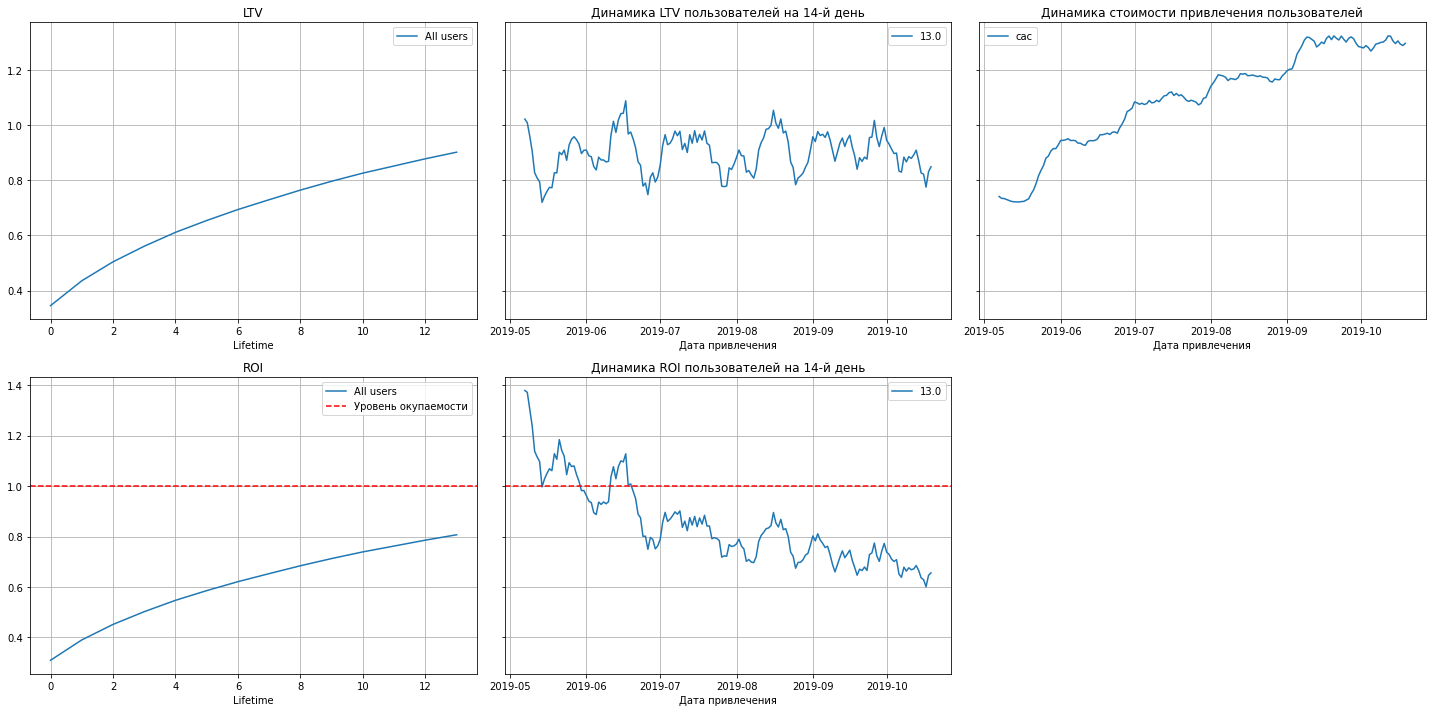

In [58]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Вывод по графикам 👆🏻:
- Общий LTV стабилен
- Рекламные расходы постепенно увеличиваются, начиная с середины мая 2019 года.
- Реклама не окупается. От начала и до середины июня периоды эффективного использования рекламных инструментов, однако с середины июня  ROI идет на понижение.

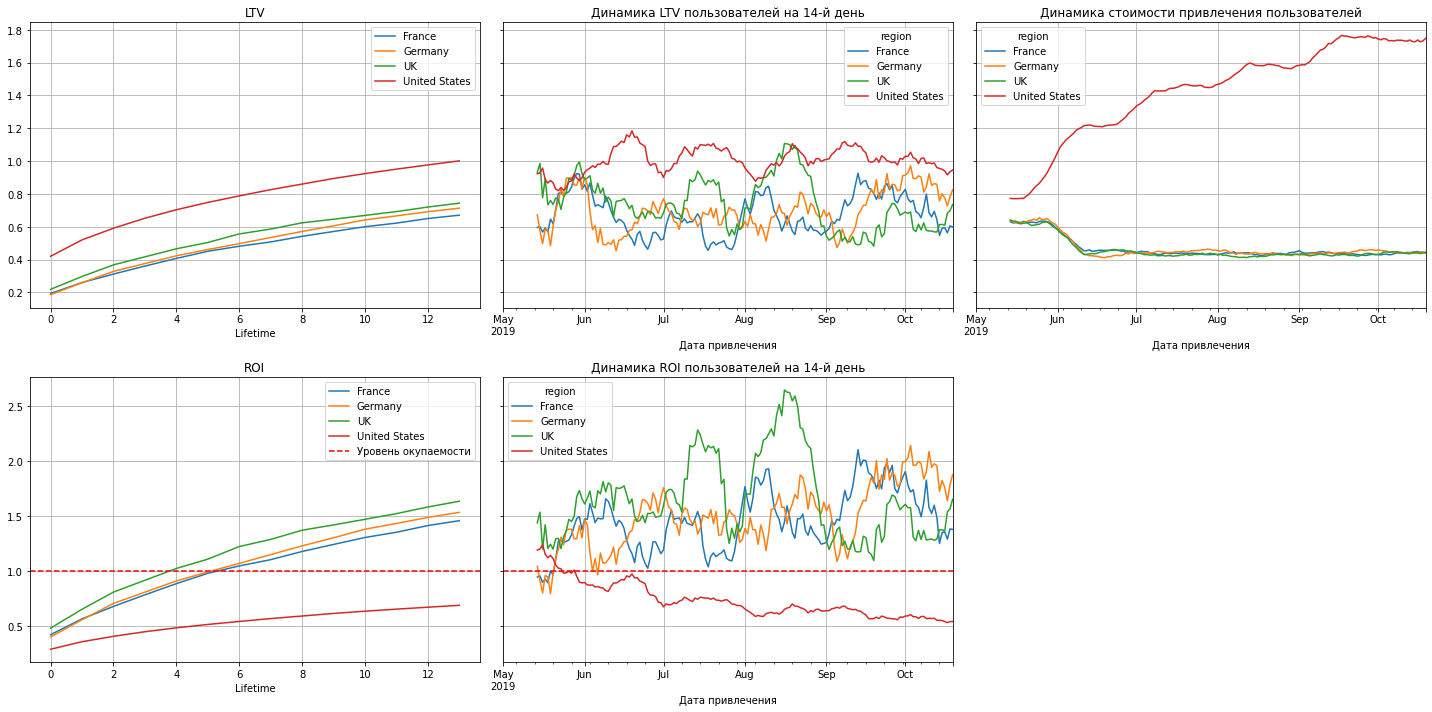

In [59]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Вывод по графикам 👆🏻:

- Пользователи США обходятся в несколько раз дороже отсальных стран по расходам. 
- Затраты на соединенные штаны постоянно высокие и растут, однако при всех вложениях  
- США являются убыточными (большие расходы на рекламу не оправдывают прирост пользователей)
- Тренд ROI находится ниже окупаемости у США

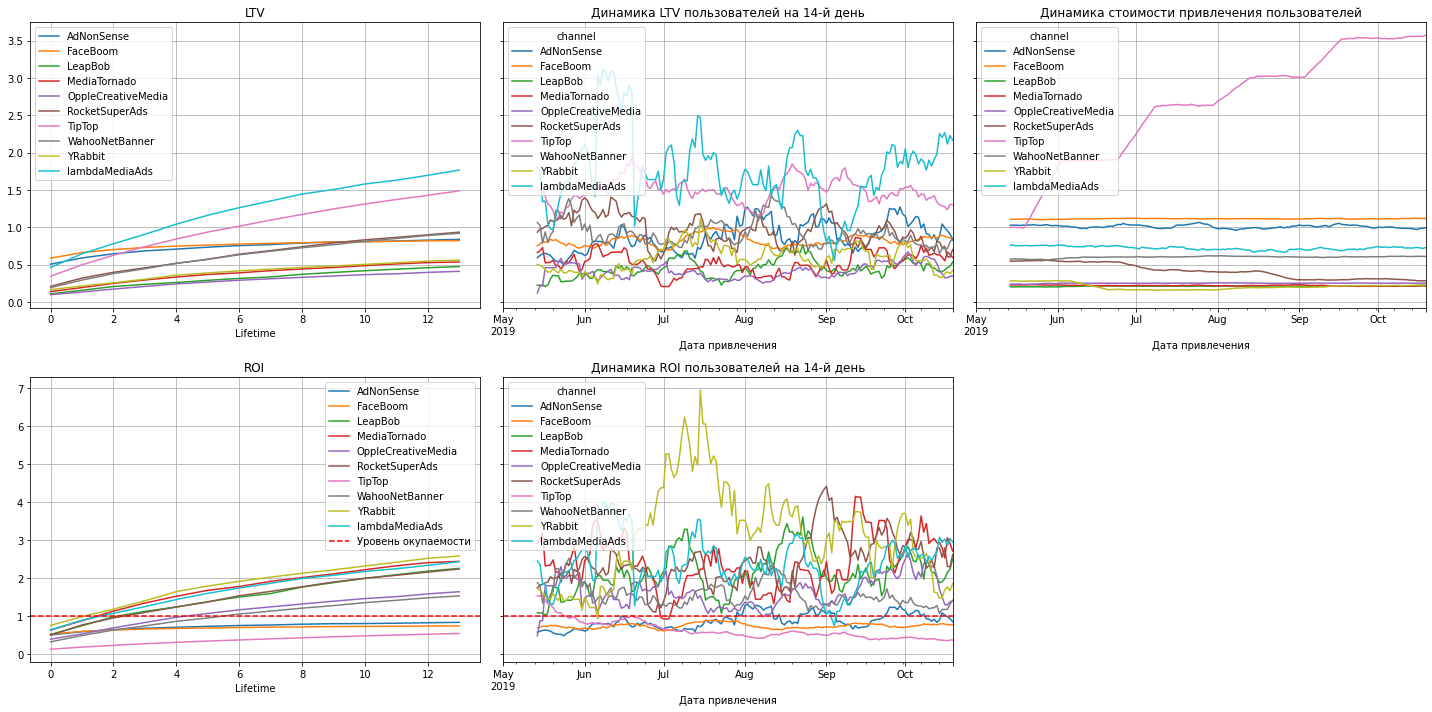

In [60]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Вывод по графикам 👆🏻:

- Наилучший показатель LTV показывает канал привлечения lambdaMediaAds
- LTV на 14-й день скачущий, нет стабильности, однако наблюдается цикличность и закономерность. 
- Затраты на канал привлечения Tip Top постоянно увеличивается, однако данный канал не превышает уровня окупаемости. Чем больше компания вкладывает в данный канал привлечения - тем больше теряет денег.  
- Интересным для вложения можно считать канал привлечения YRabbit, данный канал окупается и сильно превосходит остальные
- Топ 3 канала окупаемости - YRabbit, MediaTornado, lambdaMediaAds
- Каналы, которые не окупаются - TipTop, FaceBoom, AddNonSense

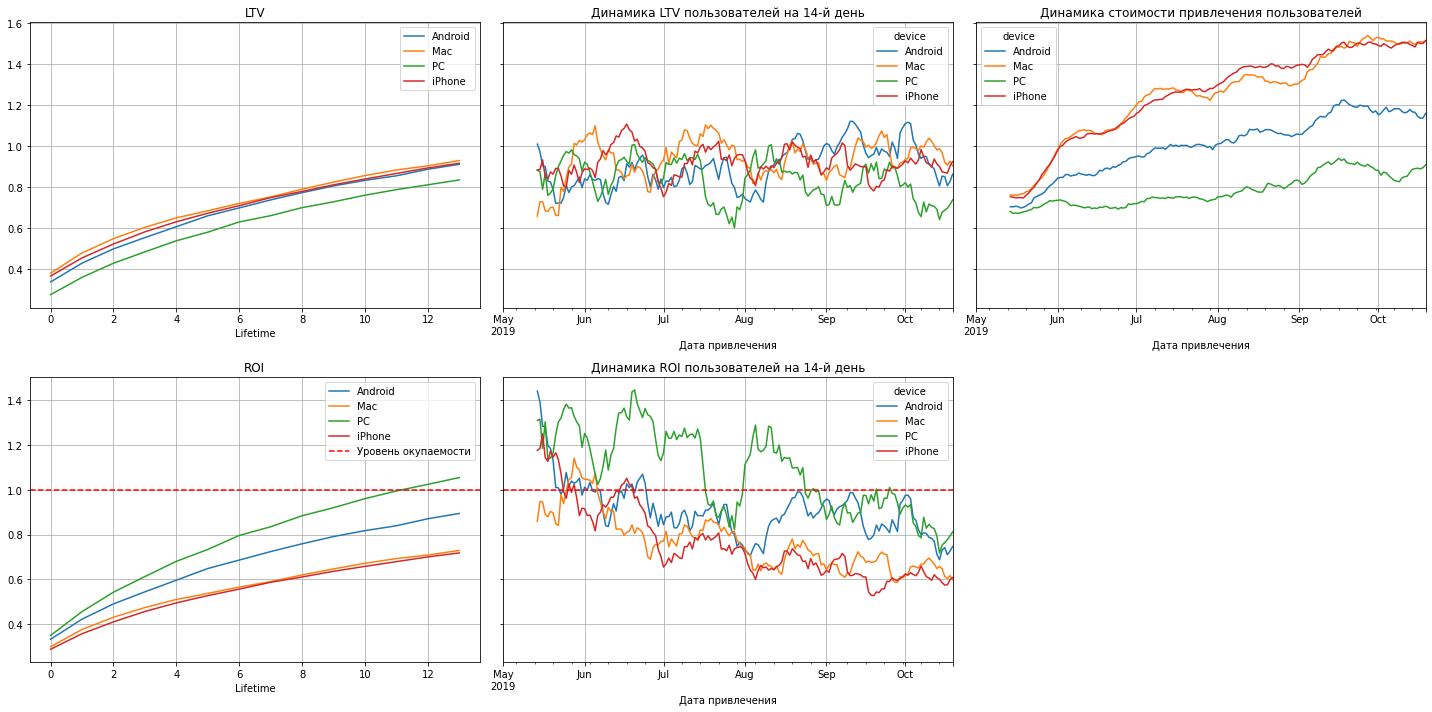

In [61]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Вывод по графикам 👆🏻:

- LTV всех устройств находится примерно на одинаковом уровне, даже в динамике на 14-й день. 
- Пользователи Айфонов и Мак обходятся компании дороже остальных. Самыми дешевыми по привлечению пользователи являются обладатели РС. 
- США являются убыточными (большие расходы на рекламу не оправдывают прирост пользователей)
- Тренд ROI находится выше окупаемости только у пользователей РС.  Однако и они с конца августа перестали окупаться на 14-й. 
- С конца августа компания получает только убытки. 

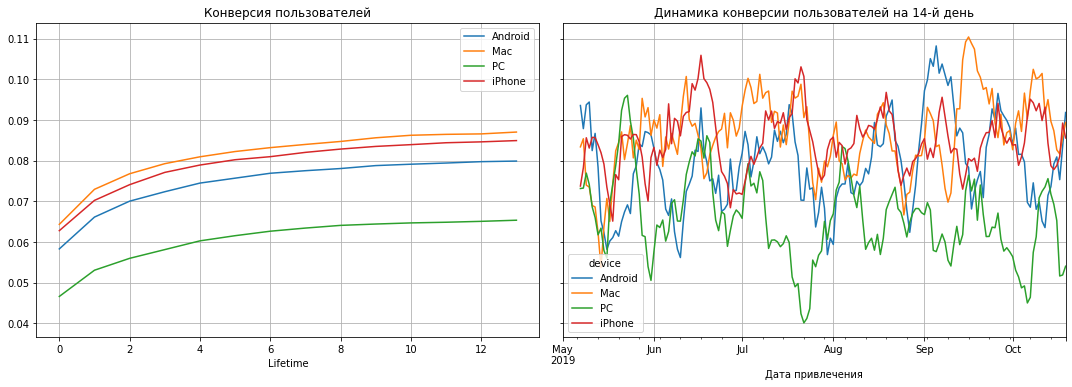

In [62]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

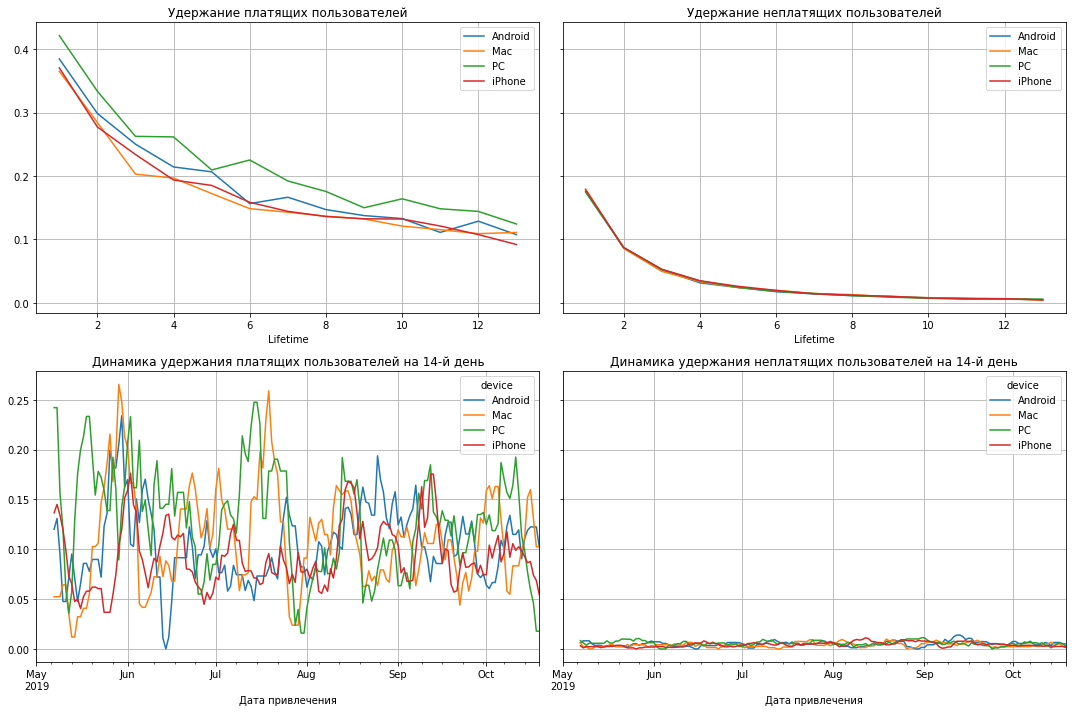

In [63]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Вывод по графикам конверсии и удержания (девайсы) 👆🏻:
- Наименьшая конверсия наблюдается среди пользователей РС, однако эти пользователи наиболее лояльны к продукты, что видно на графике удержания. 
- Возможно в середине июля и в начале октября были неудачные рекламные компании, которые принесли маленькую конверсию среди пользователей РС. 
- Удержание неплатящих пользователей для всех устройств примерно одинаковое и плохое. 

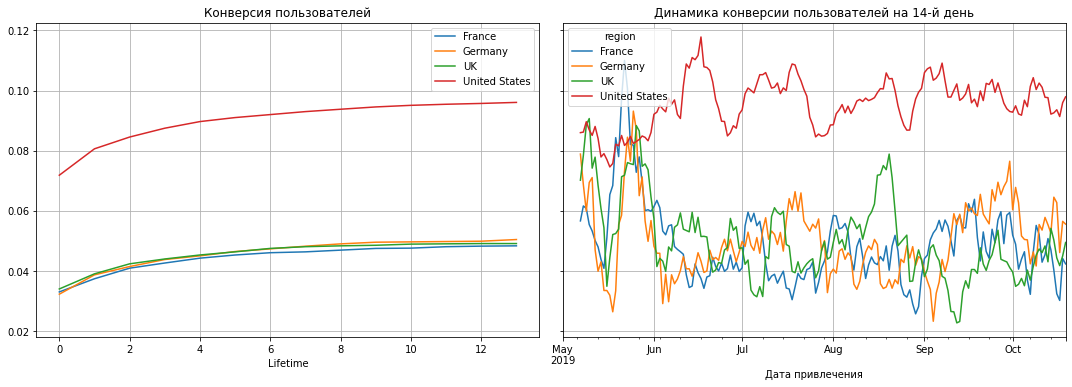

In [64]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

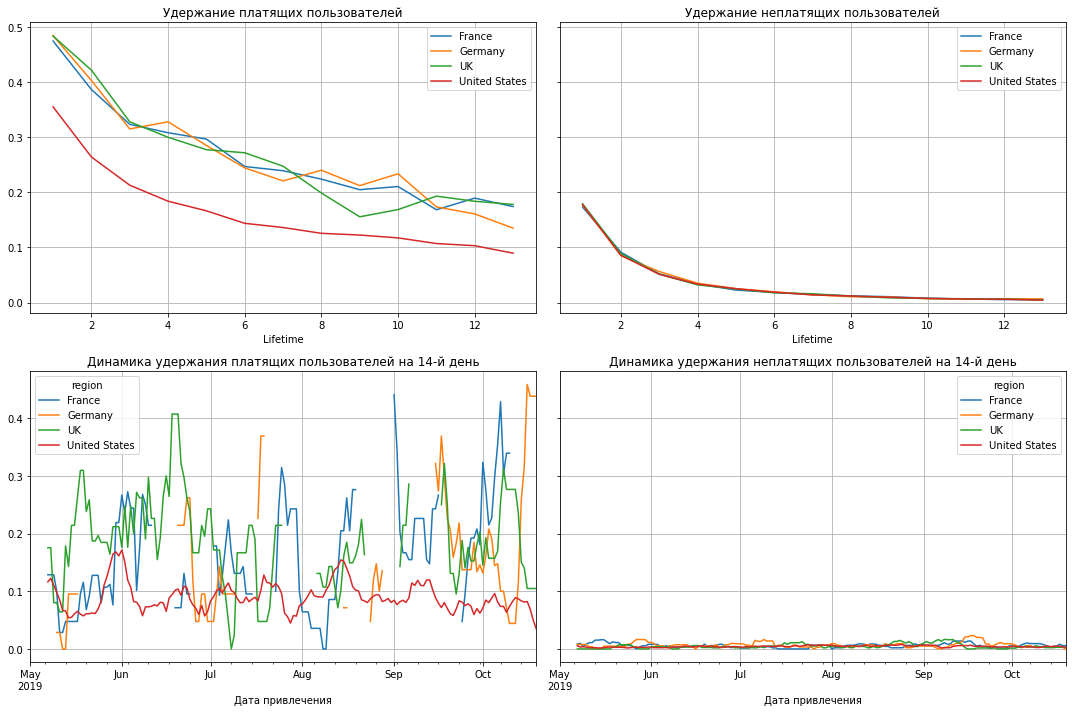

In [65]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Вывод по графикам конверсии и удержания (страны) 👆🏻:
- Наибольшая конверсия наблюдается среди пользователей США, однако эти пользователи наименее лояльны к продукты, чем остальные, что видно на графике удержания. Остальные страны примерно одинаково лояльны к продукту. 
- В конце мая видно, что была какая-то хорошая рекламная компания в странах: Германия, Франция и Великобритания, уровень конверсии там сильно возрос, однако такой бум конверсии продержался недолго. 
- Удержание неплатящих пользователей для всех стран примерно одинаково низкое. 

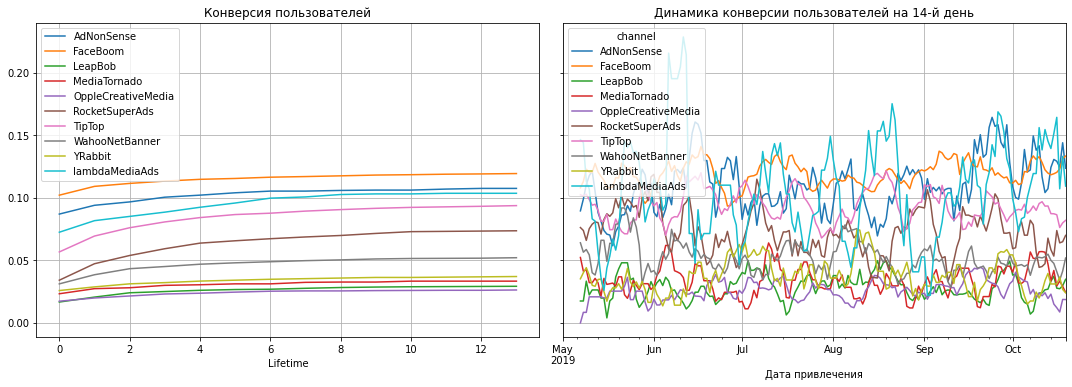

In [66]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

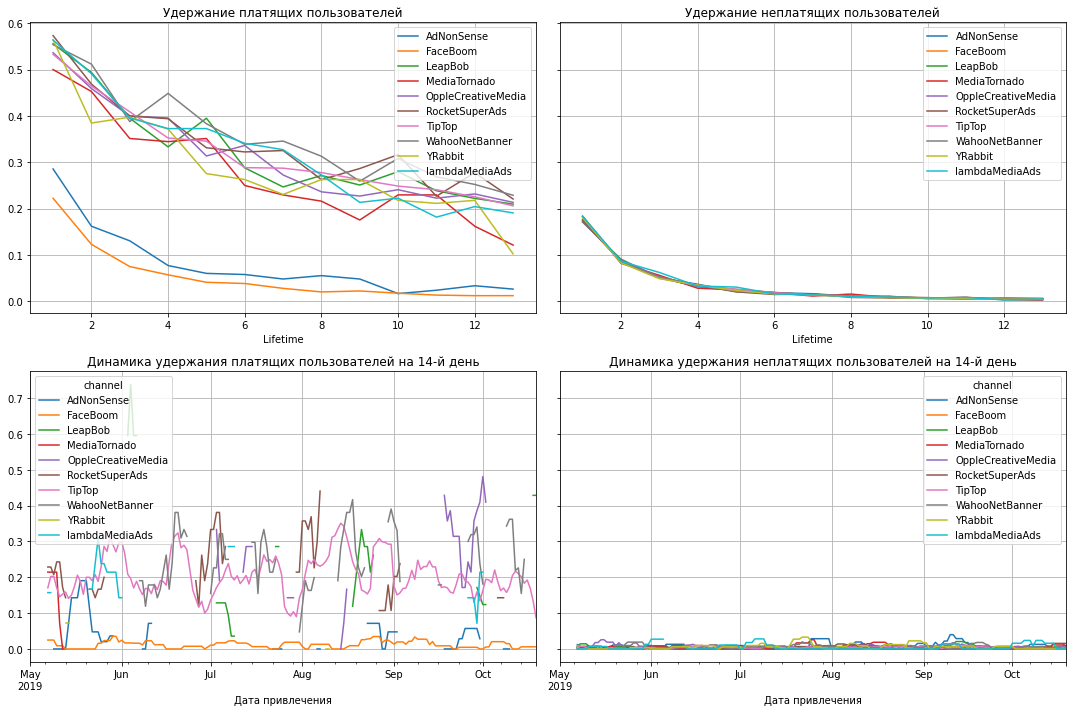

In [67]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Вывод по графикам конверсии и удержания (каналы) 👆🏻:
- Наибольшая конверсия наблюдается среди пользователей, привлеченных через каналы FaceBoom и AdNonSense, однако эти пользователи наименее лояльны к продукты, чем остальные, что видно на графике удержания. Остальные пользователи примерно одинаково лояльны к продукту. 
- На графике удержания платящих пользователей видно, что канал привлечения FaceBoom являются абсолютно не перспективным и отягчающим. 
- Удержание неплатящих пользователей для всех стран примерно одинаково низкое. 

## Выводы

- Реклама с начала и до середины июня окупалась и приносила свои плоды, однако начиная с середины июня, ROI идет на спад. Также с мая расходы на рекламу росли.
- Самыми "дорогими" пользователями являются пользователи девайсов Айфон, следует отметить, что пользователи с девайсами Мак и Айфон имеют самые низкие показатели окупаемости. 
- Смотря на окупаемость можно заметить, что Соединенные Штаты при таком количестве расходов убыточны, несмотря на то, что присутствует самый высокий LTV, но к сожалению реклама не окупает себя. 
- По показателю конверсии FaceBoom на первом месте (однако нет окупаемости), как AddNonSense и Tip Top по динамике ROI - не окупался.
- Проблемы окупаемости вызваны неправильным распределением ресурсов, и тем, что каналов привлечения очень много, видимо сложно сделать так, чтобы все или даже большая часть из них были прибыльны. 


## Чек-лист готовности

**Шаг 1. Подготовка данных**

**Надо:**
- [x]  Заменить названия столбцов (привести к нижнему регистру);
- [x]  Преобразовать данные в нужные типы. Описать, в каких столбцах заменил тип данных;
- [x]  Обработать пропуски при необходимости:

**Шаг 2. Исследовательский анализ данных**

**Надо:**
- [x]  Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- [x]  Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- [x]  Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- [x]  Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.


**Шаг 3. Маркетинг**

**Надо:**
- [x]  Посчитайте общую сумму расходов на маркетинг.
- [x]  Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- [x]  Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- [x]  Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.


**Шаг 4. Оцените окупаемость рекламы**

**Надо:**
- [x]  Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- [x]  Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- [x]  Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- [x]  Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- [x]  Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- [x]  Ответьте на такие вопросы:
    - [x]  Окупается ли реклама, направленная на привлечение пользователей в целом?
    - [x]  Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - [x]  Чем могут быть вызваны проблемы окупаемости?

**Шаг 5. Написать общий вывод**